<a href="https://colab.research.google.com/github/lephuocdat2000/Advanced-CV/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import cv2
import timeit
import itertools 

Compile darknet

In [3]:
%cd /content/drive/My\ Drive/darknet
!rm darknet
!make

/content/drive/My Drive/darknet
rm: cannot remove 'darknet': No such file or directory
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -fPIC -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmi

In [4]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!sed -i 's/LIBSO=0/LIBSO=1/' Makefile

In [5]:
def load_network_1(config_file, data_file, weights, batch_size=1):
    """
    load model description and weights from config files
    args:
        config_file (str): path to .cfg model file
        data_file (str): path to .data model file
        weights (str): path to weights
    returns:
        network: trained model
        class_names
        class_colors
    """
    network = load_net_custom(
        config_file.encode("ascii"),
        weights.encode("ascii"), 0, batch_size)
    metadata = load_meta(data_file.encode("ascii"))
    class_names = [metadata.names[i].decode("ascii") for i in range(1)]
    colors = class_colors(class_names)
    return network, class_names, colors

def darknet_helper(img, width, height):
  darknet_image = make_image(width, height, 3)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img_resized = cv2.resize(img_rgb, (width, height),
                              interpolation=cv2.INTER_LINEAR)

  # get image ratios to convert bounding boxes to proper size
  img_height, img_width, _ = img.shape
  width_ratio = img_width/width
  height_ratio = img_height/height

  # run model on darknet style image to get detections
  copy_image_from_bytes(darknet_image, img_resized.tobytes())
  detections = detect_image(network, class_names, darknet_image)
  free_image(darknet_image)
  boxes = np.array([bbox2points(bbox) for _,_,bbox in detections])
  boxes = boxes * [width_ratio, height_ratio, width_ratio, height_ratio]
  return boxes

def MatrixCreation(A,B,C,D):
    width = int(max(np.sqrt((B[1]-A[1])**2+(B[0]-A[0])**2),np.sqrt((D[1]-C[1])**2+(D[0]-C[0])**2)))
    height = int(max(np.sqrt((C[1]-A[1])**2+(C[0]-A[0])**2),np.sqrt((D[1]-B[1])**2+(D[0]-B[0])**2)))
    inputs = np.float32([A,B,C,D])
    outputs = np.float32([[0,0],
                      [width-1,0],
                      [0,height-1],
                      [width-1,height-1]])
    M = cv2.getPerspectiveTransform(inputs,outputs)
    return M,width,height

def Points_Transformation(boxes):
    x_ = boxes[:,0]+(boxes[:,2]-boxes[:,0]) / 2
    # y_ = boxes[:,1]+(boxes[:,3]-boxes[:,1]) / 2
    y_ = boxes[:,3]
    x_ = np.expand_dims(x_,axis = 1)
    y_ = np.expand_dims(y_,axis = 1) 
    # centroids = np.uint32(np.concatenate((x_,y_),axis=1))
    centroids = np.concatenate((x_,y_),axis=1)
    #list_point_to_detect = np.float32(centroids).reshape(-1,1,2)
    list_point_to_detect = centroids.reshape(-1,1,2)
    transformed_points = cv2.perspectiveTransform(list_point_to_detect, M)
    transformed_points = transformed_points.reshape(transformed_points.shape[0],transformed_points.shape[2])
    return transformed_points

def DrawnRectangel(boxes,image,point,color):
    # xmin,ymin,xmax,ymax = int(boxes[point][0]),int(boxes[point][1]),int(boxes[point][2]),int(boxes[point][3])
    xmin,ymin,xmax,ymax = boxes[point][:].astype(int)
    cv2.rectangle(image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),color,2)  

def get_birds_eye_view_image(transformed_points,green_box,red_box,eye_view_height,eye_view_width):
    blank_image = cv2.imread('/content/drive/MyDrive/Advanced-CV/black_background.png')
    blank_image = cv2.resize(blank_image,(eye_view_width,eye_view_height))
    cv2.putText(blank_image, str(len(red_box)), (120,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,0,255), 4, cv2.LINE_AA) 
    cv2.putText(blank_image, str(len(green_box)), (520,100), cv2.FONT_HERSHEY_SIMPLEX , 2, (0,255,0), 4, cv2.LINE_AA)
    for point in green_box:
        cv2.circle(blank_image,tuple(transformed_points[point].astype(int)),20,(0,255,0),-1)
    for point in red_box:
        cv2.circle(blank_image,tuple(transformed_points[point].astype(int)),20,(0,0,255),-1)
    blank_image = cv2.resize(blank_image,(eye_view_width//2,eye_view_height))
    return blank_image
     
def video_processing(video_path,real_width,real_height,pixel_width,pixel_height):
    cap = cv2.VideoCapture(video_path)
    if (cap.isOpened()==False): 
        print('Error opening video stream or file')
    else: 
      blank_image = cv2.imread('/content/drive/MyDrive/Advanced-CV/black_background.png')
      blank_image = cv2.resize(blank_image,(960,540))
      fourcc = cv2.VideoWriter_fourcc(*'XVID')
      out = cv2.VideoWriter('output.avi',fourcc, 20, (1440,540))
      while (True):
          ret, frame = cap.read()
          if ret==True:
            alter_blank_image = blank_image.copy()
            boxes = darknet_helper(frame,width,height)  
            #boxes= boxes[~np.all(boxes== 0, axis=1)]    
            transformed_points = Points_Transformation(boxes)
            if len(boxes) > 1:
                image_rect = frame.copy()
                list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
                x_y_ = []
                for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
                     if np.sqrt( ((pair[0][0] - pair[1][0])*real_width/pixel_width)**2 + ((pair[0][1] - pair[1][1])*real_height/pixel_height)**2  ) < int(distance_minimum):
                         index_pt1 = list_indexes[i][0]
                         index_pt2 = list_indexes[i][1]
                         if index_pt1 not in x_y_:
                            #draw red circle top view
                            cv2.circle(alter_blank_image,tuple(transformed_points[index_pt1].astype(int)),20,(0,0,255),-1)
                            #change red box original frame
                            DrawnRectangel(boxes,image_rect,index_pt1,(0,0,255))
                            x_y_.append(index_pt1)
                         if index_pt2 not in x_y_: 
                            #draw green circle top view    
                            cv2.circle(alter_blank_image,tuple(transformed_points[index_pt2].astype(int)),20,(0,0,255),-1)
                            #change green box original frame    
                            DrawnRectangel(boxes,image_rect,index_pt2,(0,0,255))
                            x_y_.append(index_pt2) 
                #select points to draw green box and green circle 
                diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
                for i in diff:
                   DrawnRectangel(boxes,image_rect,i,(0,255,0))
                   cv2.circle(alter_blank_image,tuple(transformed_points[i].astype(int)),20,(0,255,0),-1)
            elif len(boxes)==1: 
                 image_rect = frame.copy()
                 DrawnRectangel(boxes,image_rect,0,(0,255,0))
                 cv2.circle(alter_blank_image,tuple(transformed_points[0].astype(int)),20,(0,255,0),-1)
            else: image_rect = frame.copy()
            alter_blank_image = cv2.resize(alter_blank_image,(alter_blank_image.shape[1]//2,alter_blank_image.shape[0]))
            combined_image = np.concatenate((alter_blank_image,image_rect),axis=1)
            out.write(combined_image)
            if cv2.waitKey(1)==ord('q'): break
          else: break 
    out.release()
    return
def show_webcam(mirror=False):
    vid = cv2.VideoCapture(0)
    while True:
       ret,frame = vid.read()
       plt.imshow('frame',frame)
       if cv2.waitKey(1) & 0xFF == ord('q'):
          break
    vid.release()
    cv2.destroyAllWindows() 


In [6]:
from darknet import *
#608X608
# load in our YOLOv4 architecture network
network, class_names, class_colors = load_network_1("cfg/yolov4.cfg", "cfg/coco.data", "yolov4.weights")
width = network_width(network)
height = network_height(network)



Test trên ảnh

[[1092.0076653    76.33025285]
 [ 478.61552313  443.8243132 ]
 [ 398.59469024  461.57488337]]


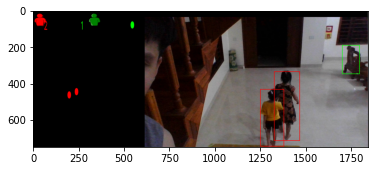

In [ ]:
# Get transformation matrix
A = [470,330]
B = [980,310]
C = [310,700]
D = [1200,680]
distance_minimum = 2.0
real_width,real_height = 7.5,8.0
pixel_width,pixel_height = B[0] - A[0], C[1]-A[1]
M,pixel_width,pixel_height = MatrixCreation(A,B,C,D)

image = cv2.imread("/content/drive/MyDrive/Advanced-CV/193593992_323953159303430_8126787994321005785_n.png")
boxes = darknet_helper(image, width, height)
transformed_points = Points_Transformation(boxes)
print(transformed_points)
if len(boxes) > 1:
    image_rect = image.copy()
    list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
    x_y_ = []
    for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
      if np.sqrt( ((pair[0][0] - pair[1][0])*real_width/pixel_width)**2 + ((pair[0][1] - pair[1][1])*real_height/pixel_height)**2  ) < int(distance_minimum):
      #change color top view
         index_pt1 = list_indexes[i][0]
         index_pt2 = list_indexes[i][1]
      #change color original frame
         DrawnRectangel(boxes,image_rect,index_pt1,(0,0,255))
         DrawnRectangel(boxes,image_rect,index_pt2,(0,0,255))
         x_y_.append(index_pt1)
         x_y_.append(index_pt2)
         diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
         for i in diff: DrawnRectangel(boxes,image_rect,i,(0,255,0))
elif len(boxes)==1: 
    image_rect = image.copy()
    DrawnRectangel(boxes,image_rect,0,(0,255,0))
else: image_rect = image.copy()
birds_eye_view_image = get_birds_eye_view_image(transformed_points,diff,x_y_,image.shape[0],image.shape[1])
combined_image = np.concatenate((birds_eye_view_image,image_rect), axis=1)
plt.imshow(cv2.cvtColor(combined_image,cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
# Get transformation matrix
A = [470,330]
B = [980,310]
C = [310,700]
D = [1200,680]
distance_minimum = 2.0
real_width,real_height = 7.5,8.0
pixel_width,pixel_height = B[0] - A[0], C[1]-A[1]
M,pixel_width,pixel_height = MatrixCreation(A,B,C,D)

image = cv2.imread("/content/drive/MyDrive/Advanced-CV/193593992_323953159303430_8126787994321005785_n.png")
boxes = darknet_helper(image, width, height)
transformed_points = Points_Transformation(boxes)
print(transformed_points)
if len(boxes) > 1:
    image_rect = image.copy()
    list_indexes = list(itertools.combinations(range(len(transformed_points)), 2))
    x_y_ = []
    for i,pair in enumerate(itertools.combinations(transformed_points, r=2)):
      if np.sqrt( ((pair[0][0] - pair[1][0])*real_width/pixel_width)**2 + ((pair[0][1] - pair[1][1])*real_height/pixel_height)**2  ) < int(distance_minimum):
      #change color top view
         index_pt1 = list_indexes[i][0]
         index_pt2 = list_indexes[i][1]
      #change color original frame
         DrawnRectangel(boxes,image_rect,index_pt1,(0,0,255))
         DrawnRectangel(boxes,image_rect,index_pt2,(0,0,255))
         x_y_.append(index_pt1)
         x_y_.append(index_pt2)
         diff = np.setdiff1d(list(range(0,len(boxes))),np.unique(x_y_))
         for i in diff: DrawnRectangel(boxes,image_rect,i,(0,255,0))
elif len(boxes)==1: 
    image_rect = image.copy()
    DrawnRectangel(boxes,image_rect,0,(0,255,0))
else: image_rect = image.copy()
birds_eye_view_image = get_birds_eye_view_image(transformed_points,diff,x_y_,image.shape[0],image.shape[1])
combined_image = np.concatenate((birds_eye_view_image,image_rect), axis=1)
plt.imshow(cv2.cvtColor(combined_image,cv2.COLOR_BGR2RGB))
plt.show()

Test video

In [ ]:
%cd /content/drive/MyDrive/

A = [470,330]
B = [980,310]
C = [320,600]
D = [1170,580]
#pixel_width,pixel_height = B[0] - A[0], C[1]-A[1]
M,pixel_width,pixel_height = MatrixCreation(A,B,C,D)
real_width,real_height = 7.5,8.0
distance_minimum = 2.0
video_path='/content/drive/MyDrive/Advanced-CV/People2_Trim.mp4'
video_processing(video_path,real_width,real_height,pixel_width,pixel_height)

/content/drive/MyDrive


Test trên ảnh

4 points image

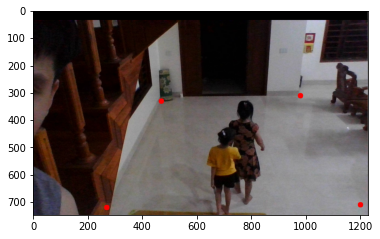

In [ ]:
image = cv2.imread('/content/drive/MyDrive/Advanced-CV/193593992_323953159303430_8126787994321005785_n.png')
cv2.circle(image,(470,330),10,(0,0,255),-1)
cv2.circle(image,(980,310),10,(0,0,255),-1)
cv2.circle(image,(270,720),10,(0,0,255),-1)
cv2.circle(image,(1200,710),10,(0,0,255),-1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

4 points video

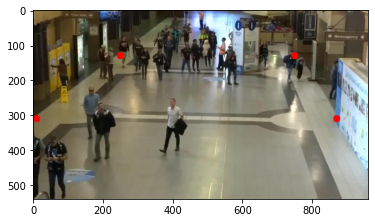

In [ ]:
A = [250,130]
B = [750,130]
C = [10,310]
D = [870,310]
pixel_widtd,pixel_height = B[0] - A[0], C[1]-A[1]
M = MatrixCreation(A,B,C,D)
cap = cv2.VideoCapture('/content/drive/MyDrive/Advanced-CV/People2_Trim.mp4')
if (cap.isOpened()==False):
    print('Error opening video stream or file')
else: 
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    while (True):
       ret, frame = cap.read()
       if ret==True:
           out = cv2.VideoWriter('output.avi',fourcc, 24,(frame.shape[1],frame.shape[0]))
           cv2.circle(frame,tuple(A),10,(0,0,255),-1)
           cv2.circle(frame,tuple(B),10,(0,0,255),-1)
           cv2.circle(frame,tuple(C),10,(0,0,255),-1)
           cv2.circle(frame,tuple(D),10,(0,0,255),-1)
           plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
           frame = cv2.warpPerspective(frame,M,(frame.shape[1],frame.shape[0]))
           break
           if cv2.waitKey(1)==ord('q'): break
           out.write(frame)
       else: break
    out.release()

#Model Validation

(342, 266, 3)


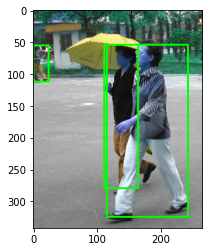

In [ ]:
image = cv2.imread('/content/FudanPed00017.png')

boxes = darknet_helper(image, width, height)
for (xmin,ymin,xmax,ymax) in boxes:
    cv2.rectangle(image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(0,255,0),2)
plt.imshow(image)
plt.show()   

In [38]:
def Sort_Array(array):
  for i in range(0,len(array)-1):
    for j in range(i+1,len(array)):
       if array[j][0] < array[i][0] :   
          array[i][0],array[j][0] = array[j][0],array[i][0]
          array[i][1],array[j][1] = array[j][1],array[i][1]
       elif (array[i][0] == array[j][0]) and (array[j][1] < array[i][1]) :   
          array[i][0],array[j][0] = array[j][0],array[i][0]
          array[i][1],array[j][1] = array[j][1],array[i][1]
  return array

def IOU_Calculation(gt_bbox,pred_bbox):
  xmin_gt,ymin_gt,xmax_gt,ymax_gt = gt_bbox
  xmin_pre,ymin_pre,xmax_pre,ymax_pre = pred_bbox
  if (xmax_gt < xmin_pre) or (ymax_gt<ymin_pre) or (xmin_gt > xmax_pre) or (ymin_gt>ymax_pre): return 0.0
  GT_bbox_area = (xmax_gt - xmin_gt + 1 ) * (ymax_gt - ymin_gt + 1 )
  Pre_bbox_area = (xmax_pre - xmin_pre + 1 ) * (ymax_pre - ymin_pre + 1 )
  xmin = max(xmin_gt,xmin_pre)
  ymin = max(ymin_gt,ymin_pre)
  xmax = min(xmax_gt,xmax_pre)
  ymax = min(ymax_gt,ymax_pre)
  intersection_area = (xmax-xmin+1)*(ymax-ymin+1)
  union_area = GT_bbox_area + Pre_bbox_area - intersection_area
  return intersection_area/union_area

def TP_FP_FN(arr,larger_arr):
  saved_idx = np.array([-1]*len(larger_arr))
  TP,FP,FN = 0,0,0
  for i in range(0,len(arr)):
     sub_arr = arr[i] - larger_arr
     sqrt_arr = np.sqrt(sub_arr[:,0]**2+sub_arr[:,1]**2)
     min_idx = np.argmin(sqrt_arr)
     saved_idx[i] = min_idx
     IOU = IOU_Calculation(gt_bbox[min_idx],boxes[i])
     if IOU >=0.5: TP+=1
     else: FP+=1
  FN = len(np.where(saved_idx!=-1)[0])
  return (TP,FP,FN)      

def Image_to_Image(array1,array2):
  if len(array1)>len(array2): TP,FP,FN = TP_FP_FN (array2,array1)
  else: TP,FP,FN = TP_FP_FN(array1,array2) 
  try: precision = TP / (TP+FP)
  except ZeroDivisionError: precision=0.0
  try: recall = TP / (TP+FN)
  except ZeroDivisionError: recall=0.0
  return (precision,recall)

def Read_Txt(file_path):  
  with open(path,'r') as f:
      lines = f.readlines()
      bbox_gt = np.zeros((len(lines),4))
      for i,line in enumerate(lines):
        coordinate = line.split()
        xmin,ymin,xmax,ymax = float(coordinate[1]) - float(coordinate[3])/2, float(coordinate[2]) - float(coordinate[4])/2,float(coordinate[1]) + float(coordinate[3])/2, float(coordinate[2]) + float(coordinate[4])/2
        bbox_gt[i][0:4] = [xmin,ymin,xmax,ymax]
  return bbox_gt

def mAP(precision_arr,recall_arr):
  recall_arr = np.sort(recall_arr)
  

[[163.999979  180.999696  300.000207  431.99992  ]
 [414.0001515 171.999988  536.0002245 486.000044 ]]
[[417.41118421 168.38157895 534.17598684 489.27631579]
 [157.21875    179.84210526 303.40460526 429.32894737]]


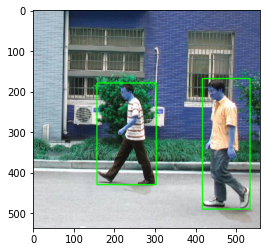

In [44]:
list_path = ['/content/drive/MyDrive/FudanPed00001.txt']
precision_arr = []
recall_arr = []
for path in list_path:
   gt_bbox = Read_Txt(path)
   image = cv2.imread('/content/drive/MyDrive/FudanPed00001.png')
   img_height,img_width = image.shape[0],image.shape[1]
   gt_bbox[:,0] = gt_bbox[:,0]*img_width
   gt_bbox[:,1] = gt_bbox[:,1]*img_height
   gt_bbox[:,2] = gt_bbox[:,2]*img_width
   gt_bbox[:,3] = gt_bbox[:,3]*img_height
   boxes = darknet_helper(image,width,height)
  #  for (xmin,ymin,xmax,ymax) in boxes:
  #   cv2.rectangle(image,(int(xmin),int(ymin)),(int(xmax),int(ymax)),(0,255,0),2)
  #  plt.imshow(image)
  #  plt.show()  
   precision,recall = Image_to_Image(gt_bbox,boxes)
   precision_arr.append(precision)
   recall_arr.append(recall)
prec_at_rec = []
for recall_level in np.linspace(0.0,1.0,11):
  try:
    args = np.where(recall_arr>recall_level)
    prec = max(precision_arr[args])
  except:
    prec = 0.0
  prec_at_rec.append(prec)
avg_prec = np.mean(prec_at_rec)
  





In [ ]:
a = np.array([[1,2],[3,4]])
b = np.array([[1,1],[2,5],[3,5]])
sub = b[0] - a
sqrt_array = np.sqrt(sub[:,0]**2 + sub[:,1]**2)
print(sqrt_array)
print(np.argmin(sqrt_array)) 

[1.         3.60555128]
0


[[0.415027 0.571828 0.243292 0.468284]
 [0.849732 0.613806 0.218247 0.585821]]
